In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import geopandas as gpd
from prompt_toolkit.utils import to_str

In [2]:
df = pd.read_csv("../../data/raw/sociometro-vasco-86-prevision-voto.csv", delimiter=";")
metadata_json_path = Path('../../data/metadata/preguntas.json')
with open(metadata_json_path, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

In [6]:
p22_map = metadata["preguntas"]["P22"]["opciones"]
p22_index_int = {int(k): v for k,v in p22_map.items()}
conteo_elecciones_pasadas= df["p22"].value_counts()
conteo_elecciones_pasadas.index = conteo_elecciones_pasadas.index.map(p22_index_int)
conteo_elecciones_pasadas.name = "Conteo de las elecciones pasadas"
conteo_elecciones_pasadas

p22
PNV/EAJ                                                          814
EH BILDU                                                         649
NO VOTÓ, SE ABSTUVO                                              374
PARTIDO SOCIALISTA DE EUSKADI-PSE-EE                             318
NO CONTESTA                                                      304
NO SABE                                                          131
PP                                                               107
NO PUDO VOTAR POR NO TENER DERECHO                                80
ELKARREKIN PODEMOS                                                74
SUMAR                                                             40
VOTÓ BLANCO                                                       38
VOX                                                               36
OTRA CANDIDATURA                                                  26
VOTÓ NULO                                                         20
NO PUDO VOTAR POR SER MENOR DE

In [7]:
metadata["preguntas"]["P25"]["texto"]

'¿QUÉ GRADO DE SIMPATÍA SIENTE POR CADA UNA DE LAS SIGUIENTES OPCIONES POLÍTICAS, EN UNA ESCALA DE 0 A 10, DONDE EL 0 SIGNIFICA NINGUNA SIMPATÍA Y EL 10 MUCHA SIMPATÍA?'

In [8]:
simpatia_partidos_map = {
    0: "0 - Ninguna simpatía",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10",
    11: "No sabe/No contesta",
}

p25_list = metadata["preguntas"]["P25"]["partidos"]
niveles_de_simpatia = []
for i, partido in enumerate(p25_list):
    col_number = "p250" + str(i+1)
    nivel_de_simpatia = df[col_number].value_counts().sort_index(ascending=False)
    nivel_de_simpatia.index = nivel_de_simpatia.index.map(simpatia_partidos_map)
    nivel_de_simpatia.name = partido
    nivel_de_simpatia.to_string()
    niveles_de_simpatia.append(nivel_de_simpatia)
p25_text = metadata["preguntas"]["P25"]["texto"]
niveles_de_simpatia

[p2501
 No sabe/No contesta     100
 10                      199
 9                       149
 8                       391
 7                       413
 6                       426
 5                       544
 4                       228
 3                       138
 2                       105
 1                        69
 0 - Ninguna simpatía    268
 Name: PNV/EAJ, dtype: int64,
 p2502
 No sabe/No contesta     111
 10                      155
 9                       140
 8                       313
 7                       358
 6                       328
 5                       416
 4                       189
 3                       141
 2                       126
 1                        71
 0 - Ninguna simpatía    682
 Name: EH BILDU, dtype: int64,
 p2503
 No sabe/No contesta     111
 10                       83
 9                        74
 8                       184
 7                       302
 6                       412
 5                       582
 4                 

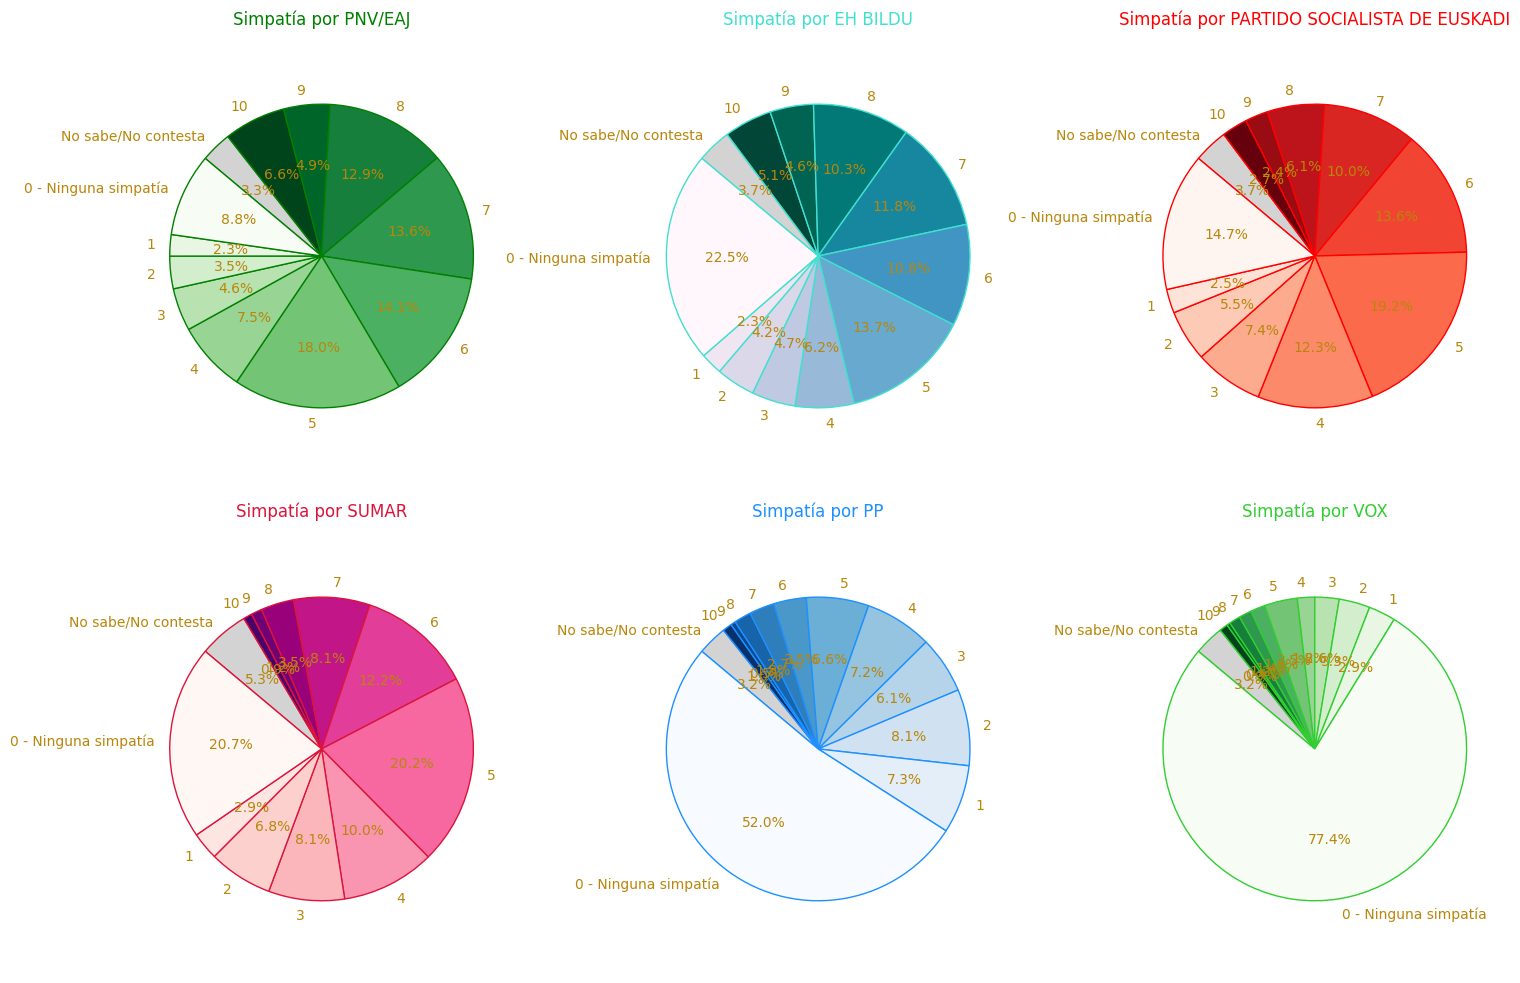

In [9]:
partido_colors = {
    "PNV/EAJ": {"colormap": "Greens", "color": "green"},
    "EH BILDU": {"colormap": "PuBuGn", "color": "turquoise"},
    "PARTIDO SOCIALISTA DE EUSKADI": {"colormap": "Reds", "color": "red"},
    "SUMAR": {"colormap": "RdPu", "color": "crimson"},
    "PP": {"colormap": "Blues", "color": "dodgerblue"},
    "VOX": {"colormap": "Greens", "color": "limegreen"},
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (partido, ax) in enumerate(zip(p25_list, axes)):
    col_number = f"p250{i+1}"
    data = df[col_number].value_counts().sort_index(ascending=False)
    data.index = data.index.map(simpatia_partidos_map)

    estilo = partido_colors.get(partido, {"colormap": "Oranges", "color": "orange"})
    colormap = plt.get_cmap(estilo["colormap"], 11)
    colors = [colormap(i) for i in range(11)]
    colors.append("lightgray")

    color_map = {label: color for label, color in zip(simpatia_partidos_map.values(), colors)}
    slice_colors = [color_map[label] for label in data.index]

    ax.pie(
        data,
        labels=data.index,
        colors=slice_colors,
        autopct='%1.1f%%',
        textprops={'color': 'darkgoldenrod'},
        startangle=140,
        counterclock=False,
        wedgeprops={'linewidth': 1, 'edgecolor': estilo['color']}
    )
    ax.set_title(f"Simpatía por {partido}", color=estilo["color"])
    ax.axis('equal')

plt.tight_layout()
plt.show()

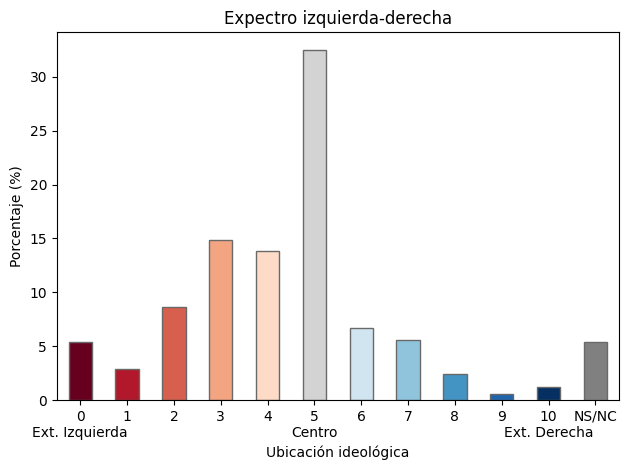

In [10]:
p32_text = metadata["preguntas"]["P32"]["texto"]
etiquetas_p32 = {
 0:    "0\nExt. Izquierda",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5\nCentro",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10\nExt. Derecha",
    11: "NS/NC"
}
colores_gradiente = [plt.get_cmap('RdBu')(i / 10) for i in range(11)]
colores_gradiente[5] = "lightgray"
colores_gradiente.append("gray")
conteo_izquierda_derecha = df["p32"].value_counts(normalize=True) * 100
conteo_izquierda_derecha = conteo_izquierda_derecha.sort_index(ascending=True)
conteo_izquierda_derecha.index = conteo_izquierda_derecha.index.map(etiquetas_p32)
ax = conteo_izquierda_derecha.plot(kind='bar', color=colores_gradiente, title="Expectro izquierda-derecha", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Ubicación ideológica")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

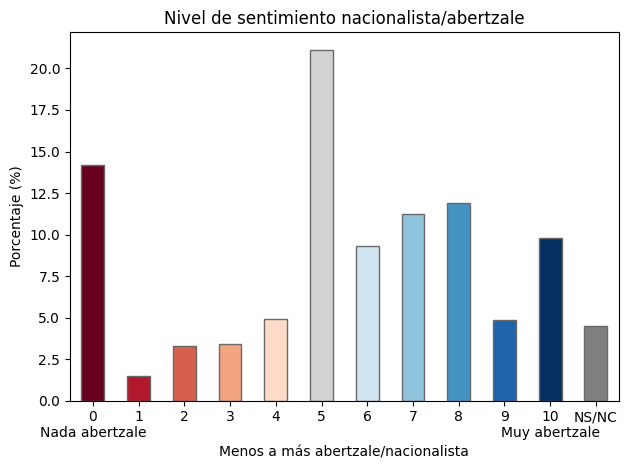

In [11]:
etiquetas_p33 = {
 0:    "0\nNada abertzale",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10\nMuy abertzale",
    11: "NS/NC"
}
colores_gradiente = [plt.get_cmap('RdBu')(i / 10) for i in range(11)]
colores_gradiente[5] = "lightgray"
colores_gradiente.append("gray")
conteo_sentimiento_aberzale = df["p33"].value_counts(normalize=True) * 100
conteo_sentimiento_aberzale = conteo_sentimiento_aberzale.sort_index(ascending=True)
conteo_sentimiento_aberzale.index = conteo_sentimiento_aberzale.index.map(etiquetas_p33)
ax = conteo_sentimiento_aberzale.plot(kind='bar', color=colores_gradiente, title="Nivel de sentimiento nacionalista/abertzale", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Menos a más abertzale/nacionalista")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

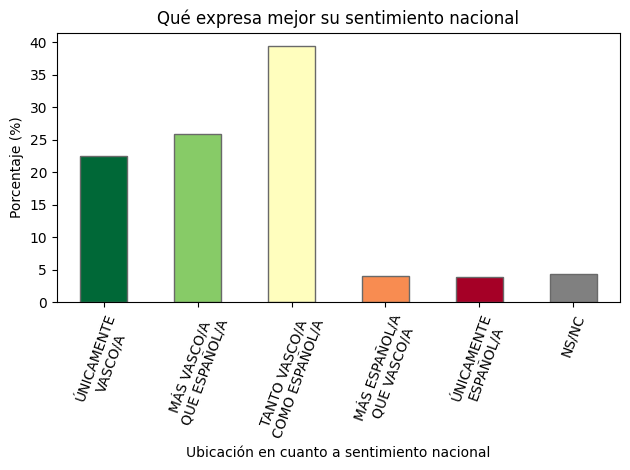

In [12]:
etiquetas_p34 = {
    1: "ÚNICAMENTE\nVASCO/A",
    2: "MÁS VASCO/A\nQUE ESPAÑOL/A",
    3: "TANTO VASCO/A\nCOMO ESPAÑOL/A",
    4: "MÁS ESPAÑOL/A\nQUE VASCO/A",
    5: "ÚNICAMENTE\nESPAÑOL/A",
    6: "NS/NC"
}

colores_gradiente = [plt.get_cmap('RdYlGn_r')(i /4) for i in range(5)]
colores_gradiente.append("gray")
conteo_sentimiento_nacional = df["p34"].value_counts(normalize=True) * 100
conteo_sentimiento_nacional = conteo_sentimiento_nacional.sort_index(ascending=True)
conteo_sentimiento_nacional.index = conteo_sentimiento_nacional.index.map(etiquetas_p34)
ax = conteo_sentimiento_nacional.plot(kind='bar', color=colores_gradiente, title="Qué expresa mejor su sentimiento nacional", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Ubicación en cuanto a sentimiento nacional")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

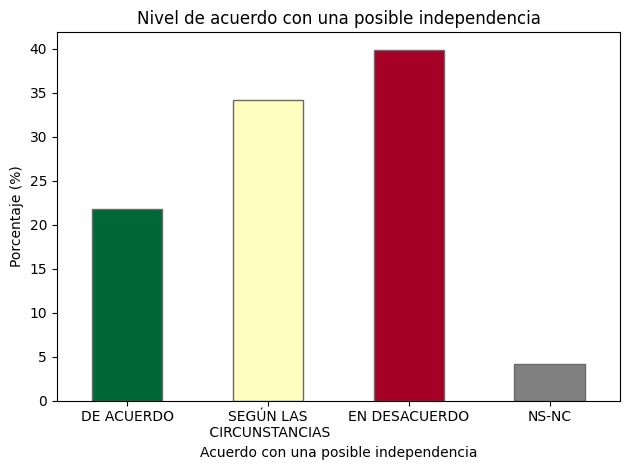

p35
DE ACUERDO                    21.749175
SEGÚN LAS\n CIRCUNSTANCIAS    34.158416
EN DESACUERDO                 39.900990
NS-NC                          4.191419
Name: proportion, dtype: float64

In [13]:
etiquetas_p35 = {
          1: "DE ACUERDO",
          2: "SEGÚN LAS\n CIRCUNSTANCIAS",
          3: "EN DESACUERDO",
          4: "NS-NC"
}

colores_gradiente = [plt.get_cmap('RdYlGn_r')(i /2) for i in range(3)]
colores_gradiente.append("gray")
conteo_acuerdo_independencia = df["p35"].value_counts(normalize=True) * 100
conteo_acuerdo_independencia = conteo_acuerdo_independencia.sort_index(ascending=True)
conteo_acuerdo_independencia.index = conteo_acuerdo_independencia.index.map(etiquetas_p35)
ax = conteo_acuerdo_independencia.plot(kind='bar', color=colores_gradiente, title="Nivel de acuerdo con una posible independencia", edgecolor="dimgray")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Acuerdo con una posible independencia")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
conteo_acuerdo_independencia

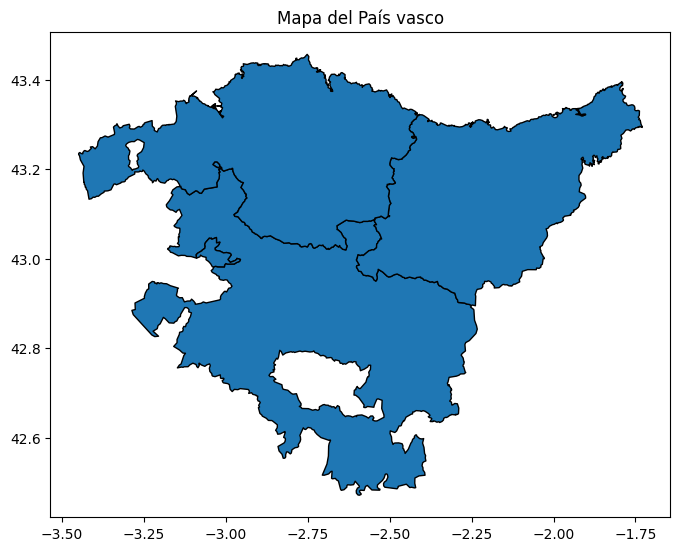

In [ ]:
euskadi = gpd.read_file("../../data/raw/euskadi.geojson")
euskadi.plot(edgecolor="black", figsize=(8,8), color=green)
plt.title("Mapa del País vasco")
plt.show()